This jupyter notebook introduces the steps on how to implement a text to image GAN generator. The aim of this tutorial is to build a simple model that generate images which describe the given text. For simplicity mnist fashion is used to generate images from a single word given. Same steps can be applied for any text to image generation model however model fine tuning might be necessary for generating high resolution images.

# Import Modules

In [1]:
import numpy as np

# Dataset
from tensorflow.keras.datasets import fashion_mnist

# To build the model and set inputs and outputs
from tensorflow.keras.models import Model

# Layers needed to build the GAN model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import Embedding, LSTM, BatchNormalization, Activation, UpSampling2D, Conv2D, LeakyReLU, Conv2DTranspose

# Optimizer to get optimal weights
from tensorflow.keras.optimizers import Adam

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Data Loading and Preparation

## Pre-processing

In [11]:
# Load train and test dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Reshape images
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalize image data between [,]]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define class names
num_classes = 10
class_names = ['T-shirt/top', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'Ankle boot']

# Change the labels into a single column and multiple rows format
y_train1 = y_train.reshape(-1, 1)
y_test1 = y_test.reshape(-1, 1)

## Visualize the data

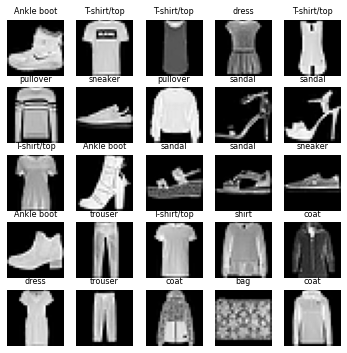

In [8]:
i = 0
j = 0
k = 0
fig, axs = plt.subplots(5, 5, figsize=(6, 6))
# loop over all generated images
for img in X_train[:25]:
    # use the imshow from matplotlib library to show images by specifing their shape
    axs[i,j].imshow(img.reshape((28, 28)), cmap='gray')
    axs[i,j].set_title(class_names[y_train[k]], fontsize=8)
    axs[i,j].axis('off')
    j += 1
    k = k + 1
    if j == 5:
        j = 0
        i = i + 1
plt.show()

# Build the Models

## The generator

In [9]:
# Define the generator model
def build_generator():
  # Define the shape if input 1 (label)
  input_embed = Input(shape=(1,))
  
  # Map the input data into high dimensional space vector
  se1 = Embedding(num_classes, 300, mask_zero=True)(input_embed)
  # Prevent overfitting
  se2 = Dropout(0.5)(se1)
  # Capture long-term dependencies and maintain memory of embedding layer output
  se3 = LSTM(256)(se2)
  
  # Define the shape of input 2 (noise)
  input_noise = Input(shape=(100,))
  
  # Pass the noise through a dense layer to make two inputs with same dimensions
  fe2 = Dense(256, activation='relu')(input_noise)
  
  # Concatenate both inputs
  gen_input = Concatenate(axis=1)([fe2, se3])
  
  # Feed the gen_input to a dense layer
  x = Dense(32 * 7 * 7, use_bias=False)(gen_input)
  x = LeakyReLU()(x)
  
  # Reshape output of dense layer to (7, 7, 32)
  x = Reshape((7, 7, 32), input_shape=(32 * 7 * 7,))(x)
  
  # Upsample to 14x14
  x = UpSampling2D(size=(2, 2))(x)
  x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  
  # Upsample to 28x28
  x = UpSampling2D(size=(2, 2))(x)
  x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  
  # Output layer with shape (28, 28, 1)
  x = Conv2D(1, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
  x = Activation(activation='sigmoid')(x)
  
  # Define the model inputs and outputs
  model = Model(inputs=[input_embed, input_noise], outputs=x)
  return model


In [12]:
generator = build_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 300)       3000        ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1, 300)       0           ['embedding[0][0]']              
                                                                                              

## The Discriminator

In [13]:
def build_discriminator():
  # Define the shape of input 1 (image)
  input_target_image = Input(shape=(28, 28, 1))
  # Define the shape of input 2 (label)
  input_label = input_embed = Input(shape=(1,))
  
  # Map the input data into high dimensional space vector
  se1 = Embedding(num_classes, 300, mask_zero=True)(input_embed)
  # Prevent overfitting
  se2 = Dropout(0.5)(se1)
  # Capture long-term dependencies and maintain memory of embedding layer output
  se3 = LSTM(7*7*8)(se2)
  # Reshape the output of LSTM layer to (7,7,8)
  se4 = Reshape((7, 7, 8))(se3)
  # Upsample to 14x14
  se5 = Conv2DTranspose(4, (1, 1), strides=(2, 2), padding='same')(se4)
  se6 = BatchNormalization()(se5)
  se7 = LeakyReLU(alpha=0.01)(se6)
  # Upsample to 28*28
  se8 = Conv2DTranspose(1, (2, 2), strides = (2, 2), padding = 'same', activation = "sigmoid")(se7)
  se9 = BatchNormalization()(se8)
  se10 = LeakyReLU(alpha=0.01)(se9)
  
  # Concatenate both inputs
  merged = Concatenate()([input_target_image, se10])
  
  # Downsample to 14*14
  x = Conv2D(64, kernel_size=4, strides=2, padding='same')(merged)
  x = LeakyReLU(alpha=0.2)(x)
  
  # Downsample to 7*7
  x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  # Downsample to 4*4
  x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  
  # Downsample to 2*2
  x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  
  # Change data to 1D
  x = Flatten()(x)
  
  # Output layer
  output = Dense(1, activation='sigmoid')(x)
  
  # Create the model
  disc_model = Model([input_target_image, input_label], outputs=output)
  
  # Compile model
  discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5)
  disc_model.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)
  return disc_model

In [14]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 300)       3000        ['input_5[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 1, 300)       0           ['embedding_1[0][0]']            
                                                                                                  
 lstm_1 (LSTM)                  (None, 392)          1086624     ['dropout_1[0][0]']              
                                                                                            

## Build GAN

In [15]:
def build_adversarial(generator_model, discriminator_model):
  # Define the shape of input 1 (label)
  input_layer1 = Input(shape=(1,))
  # Define the shape of input 2 (noise)
  input_layer2 = Input(shape=(100,))
  
  # Define generator output
  x = generator_model([input_layer1, input_layer2])
  
  # Freeze the discriminator
  discriminator_model.trainable = False
  # Define discriminator output
  probabilities = discriminator_model([x, input_layer1])
  
  # Build GAN model
  adversarial_model = Model(inputs = [input_layer1, input_layer2], outputs = [probabilities, x])
  
  # Compile GAN model
  gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  adversarial_model.compile(loss = ["binary_crossentropy", "mae"], optimizer = gan_optimizer, loss_weights=[1, 100])
  return adversarial_model

In [16]:
gan_model = build_adversarial(generator, discriminator)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             (None, 28, 28, 1)    2734520     ['input_6[0][0]',                
                                                                  'input_7[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            3850850     ['model[0][0]',            

# Define plot function

In [ ]:
def print_generated_images(noise, y):
    '''
    A function that takes the random generated noise, generates the images and plots them
    '''
    # use the trained generator to generate images from noise
    gen_imgs = generator.predict([y, noise])

    i = 0
    j = 0
    k = 0
    fig, axs = plt.subplots(5, 5, figsize=(8, 8))
    # loop over all generated images
    for img in gen_imgs[:25]:
        # use the imshow from matplotlib library to show images by specifing their shape
        axs[i,j].imshow(img.reshape((28, 28)), cmap='gray')
        axs[i,j].set_title(class_names[y[k][0]], fontsize=10)
        axs[i,j].axis('off')
        j += 1
        k += 1
        if j == 5:
            j = 0
            i = i + 1

    plt.show()

# Custom Training Loop

In [ ]:


def training(generator, discriminator, gan, train_images, train_labels, test_labels, noise_dim, epochs, batch_size):
    # to set the batch size
    steps = len(train_images) // batch_size

    # enumerate over epochs
    for e in range(epochs):
        # enumerate batches over the training data
        for b in range(steps):
            noise = np.random.normal(0, 1, [batch_size, noise_dim])

            # get a random real images from the training data
            idx = np.random.randint(0, train_images.shape[0], batch_size)
            real_imgs = train_images[idx]
            y = train_labels[idx]
            # reshape the images
            real_imgs = real_imgs.reshape((batch_size, 28, 28, 1))

            # create fake images by the generator
            fake_images = generator.predict([y, noise])

            # generate fake labels generated images as zeros
            fake_labels = np.zeros([batch_size, 1])
            # generate real labels for real data as ones
            real_labels = np.ones([batch_size, 1])*0.9

            discriminator.trainable = True
            # calculate the loss of real images
            discriminator_loss_real = discriminator.train_on_batch([real_imgs, y], real_labels)
            discriminator_loss_fake = discriminator.train_on_batch([fake_images, y], fake_labels)
            discriminator_loss_wrong = discriminator.train_on_batch([fake_images[: batch_size-1], y[1:]], fake_labels[1:])

            discriminator_loss = 0.5 * np.add(discriminator_loss_real,
                                              0.5 * np.add(discriminator_loss_wrong, discriminator_loss_fake))

            # calculate the generator loss
            noise = np.random.normal(0, 1, [batch_size, noise_dim])
            generator_loss = gan.train_on_batch([y, noise], [real_labels, real_imgs])

            # if the remainder of dividing current epoch number by 10 equal to 0 print the following image
            if e % 10 == 0:
                print('Epoch: ', e, ' Generator Loss: ', generator_loss, ' Discriminator Loss: ',
                      discriminator_loss)

        # if this is the last epoch print the generated images
        if e % 10 == 0 or e == epochs - 1:
            idx = np.random.randint(0, test_labels.shape[0], batch_size)
            y_t = test_labels[idx]
            print_generated_images(noise, y_t)

# Train the model

In [ ]:
training(generator, discriminator, gan_model, X_train, y_train1, y_test1, 100, 100, 128) 